In [183]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1")

# wiki llm

from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

tools = [wiki_tool]

llm_with_wiki = llm.bind_tools(tools)

In [184]:

# State
from pydantic import BaseModel
from typing import Annotated, Optional
from typing_extensions import TypedDict
from operator import add
from langgraph.graph import add_messages, MessagesState
from langchain_core.messages import AnyMessage

# Only gets called when the property is updated
def increment_step(orig, new):
  
  print(f"{orig=}{new=}")
  if orig == None:
    return 1
  return orig + 1
  
class InputState(BaseModel):
  question: str
  
class OutputState(BaseModel):
  answer: str

class OverallState(BaseModel):
  messages: Annotated[list[AnyMessage], add_messages] = []
  question: str
  answer: str = None
  notes: Annotated[list[str], add] = None
  search_docs: Annotated[list[str], add] = None
  step_num: Annotated[int, increment_step] = 0
  
  

In [185]:
# Node
from langchain_core.messages import HumanMessage

def input_node(state: InputState):
  return {
    'messages': [HumanMessage(content=state.question)]
  }

def wiki_calling_llm(state):
  return {
    'messages': [llm_with_wiki.invoke(state.messages)]
  }

def search_doc_saving_node(state):
  wiki_result = state.messages[-1].content
  return {
    'search_docs': [wiki_result],
    'step_num': 20
  }
  
def output_node(state: OverallState) -> OutputState:
  answer = state.messages[-1].content
  return {
    'answer': answer
  }
  

from typing import Literal

# edge Not in use
def wiki_result_condition(state) -> Literal['tools', 'output_node']:
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get("messages", [])):
        ai_message = messages[-1]
    elif messages := getattr(state, "messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "output_node"


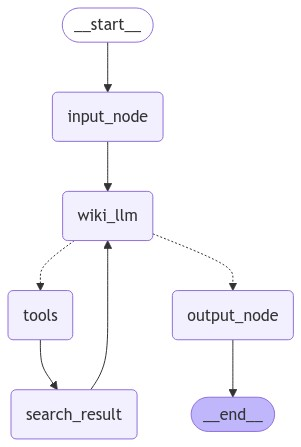

In [186]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(OverallState, input=InputState, output=OutputState)

builder.add_node('input_node', input_node)
builder.add_node('wiki_llm', wiki_calling_llm)
builder.add_node('search_result', search_doc_saving_node)
builder.add_node('output_node', output_node)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'input_node')
builder.add_edge("input_node", "wiki_llm")
builder.add_conditional_edges('wiki_llm', wiki_result_condition)
builder.add_edge('tools', 'search_result')
builder.add_edge('search_result', 'wiki_llm')
builder.add_edge('output_node', END)

graph = builder.compile()


from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [187]:
state = {
  'question': "Who is Stephen?"
}

res = graph.invoke(state)

orig=0new=20


In [188]:
res